In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv('/kaggle/input/thyroid-cancer-risk-dataset/thyroid_cancer_risk_data.csv')

In [3]:
df.head()

,Patient_ID,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,1,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,2,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,3,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,4,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,5,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [4]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 수행
le = LabelEncoder()
df['Diagnosis'] = le.fit_transform(df['Diagnosis'])  # 'Benign' -> 0, 'Malignant' -> 1
df.Diagnosis.value_counts()

Diagnosis
0    163196
1     49495
Name: count, dtype: int64

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy.stats import ttest_ind, chi2_contingency

# # 타겟 변수 (Diagnosis)
# y_col = "Diagnosis"
# y = df[y_col]

# # 독립 변수(X) 설정 (Patient_ID 제거)
# X = df.drop(columns=[y_col, "Patient_ID", "Country"])

# # 연속형 변수 (float, int)와 범주형 변수 분리
# continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# categorical_vars = X.select_dtypes(include=["object"]).columns.tolist()

# significant_features = []
# alpha = 0.05  # 유의수준

# # 연속형 변수: t-test 수행 (Diagnosis가 이진 변수(0,1)인 경우)
# for col in continuous_vars:
#     groups = df[y_col].unique()
#     if len(groups) == 2:
#         group1 = df[df[y_col] == groups[0]][col]
#         group2 = df[df[y_col] == groups[1]][col]
#         stat, p_value = ttest_ind(group1, group2, equal_var=False, nan_policy='omit')
#         if p_value < alpha:
#             significant_features.append(col)
#     else:
#         # 다중 그룹인 경우 ANOVA 사용
#         from scipy.stats import f_oneway
#         grouped_data = [df[df[y_col] == group][col] for group in groups]
#         stat, p_value = f_oneway(*grouped_data)
#         if p_value < alpha:
#             significant_features.append(col)

# # 범주형 변수: 카이제곱 검정 수행
# for col in categorical_vars:
#     contingency_table = pd.crosstab(df[col], df[y_col])
#     chi2, p_value, _, _ = chi2_contingency(contingency_table)
#     if p_value < alpha:
#         significant_features.append(col)

# print("✅ 유의미한 feature:", significant_features)

### X, Y 나누기

In [6]:
# 타겟 변수 (Diagnosis)
y_col = "Diagnosis"
y = df[y_col]

# 독립 변수(X) 설정 (Patient_ID 제거)
X = df.drop(columns=[y_col, "Patient_ID", "Country"])

### XGBoost 실행 전, 범주형 피처들 숫자형으로 변환

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# ✅ Label Encoding 적용할 컬럼 (문자형 → 숫자형 변환)
categorical_cols = ["Gender", "Ethnicity", "Family_History", "Radiation_Exposure", 
                    "Iodine_Deficiency", "Smoking", "Obesity", "Diabetes", "Thyroid_Cancer_Risk"]

# ✅ 각 컬럼에 대해 Label Encoding 수행
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # 문자형 → 숫자형 변환

# ✅ 데이터 타입 확인 (모두 숫자로 변환되었는지)
print(X.dtypes)

Age                      int64
Gender                   int64
Ethnicity                int64
Family_History           int64
Radiation_Exposure       int64
Iodine_Deficiency        int64
Smoking                  int64
Obesity                  int64
Diabetes                 int64
TSH_Level              float64
T3_Level               float64
T4_Level               float64
Nodule_Size            float64
Thyroid_Cancer_Risk      int64
dtype: object


## Train-Test 비율 변경했을 때의 차이 알아보기

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ✅ Train-Test 비율 리스트 (50:50 ~ 90:10)
train_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
results = []

# ✅ 각 비율에 대해 모델 성능 평가
for ratio in train_ratios:
    print(f"\n🔹 Train 비율: {int(ratio * 100)}% ({int(X.shape[0] * ratio)} samples)")

    # ✅ Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio, random_state=42, stratify=y)

    # ✅ XGBoost 학습 및 평가
    xgb_model = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.05, eval_metric="logloss", use_label_encoder=False)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    acc_xgb = accuracy_score(y_test, y_pred_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb)

    # ✅ CatBoost 학습 및 평가
    catboost_model = CatBoostClassifier(n_estimators=500, depth=6, learning_rate=0.05, verbose=0)
    catboost_model.fit(X_train, y_train)
    y_pred_cat = catboost_model.predict(X_test)

    acc_cat = accuracy_score(y_test, y_pred_cat)
    f1_cat = f1_score(y_test, y_pred_cat)

    # ✅ 결과 저장
    results.append({
        "Train Ratio": ratio,
        "XGBoost Accuracy": acc_xgb,
        "XGBoost F1": f1_xgb,
        "CatBoost Accuracy": acc_cat,
        "CatBoost F1": f1_cat
    })

# ✅ DataFrame 변환
df_results = pd.DataFrame(results)

df_results


🔹 Train 비율: 50% (106345 samples)

🔹 Train 비율: 60% (127614 samples)

🔹 Train 비율: 70% (148883 samples)

🔹 Train 비율: 80% (170152 samples)

🔹 Train 비율: 90% (191421 samples)


,Train Ratio,XGBoost Accuracy,XGBoost F1,CatBoost Accuracy,CatBoost F1
0,0.5,0.826359,0.543892,0.827064,0.547633
1,0.6,0.827133,0.546626,0.827521,0.548936
2,0.7,0.828188,0.549571,0.828564,0.551662
3,0.8,0.828957,0.552191,0.829357,0.554143
4,0.9,0.826657,0.547663,0.827174,0.549620


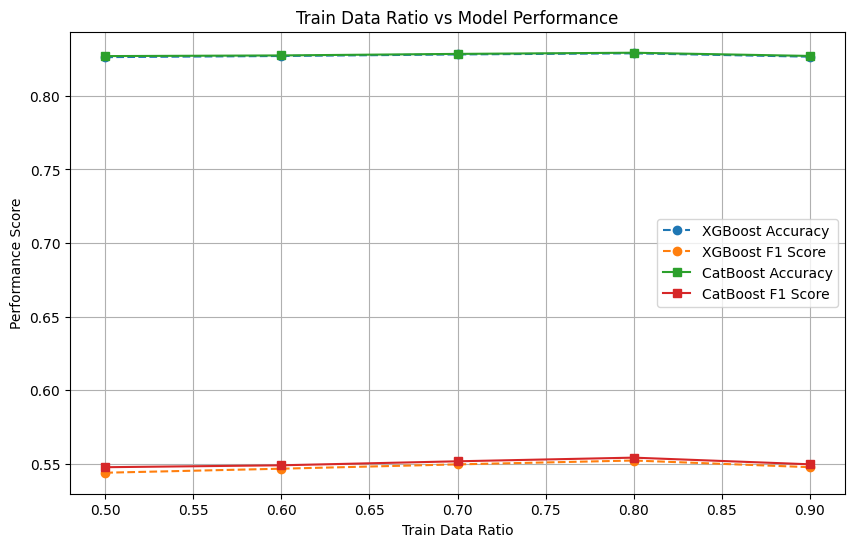

In [10]:
import matplotlib.pyplot as plt

# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

# XGBoost 성능 변화
plt.plot(df_results["Train Ratio"], df_results["XGBoost Accuracy"], marker="o", linestyle="--", label="XGBoost Accuracy")
plt.plot(df_results["Train Ratio"], df_results["XGBoost F1"], marker="o", linestyle="--", label="XGBoost F1 Score")

# CatBoost 성능 변화
plt.plot(df_results["Train Ratio"], df_results["CatBoost Accuracy"], marker="s", linestyle="-", label="CatBoost Accuracy")
plt.plot(df_results["Train Ratio"], df_results["CatBoost F1"], marker="s", linestyle="-", label="CatBoost F1 Score")

plt.xlabel("Train Data Ratio")
plt.ylabel("Performance Score")
plt.title("Train Data Ratio vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ✅ 실험할 샘플 크기 리스트
sample_sizes = [100, 300, 500, 1000, 3000, 5000, 10000, 30000, 50000, 100000, 150000, 210000]
results = []

# ✅ 각 샘플 크기에 대해 모델 성능 평가
for size in sample_sizes:
    print(f"\n🔹 데이터 크기: {size} samples")

    # ✅ 데이터 랜덤 샘플링
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=size, random_state=42, stratify=y)

    # ✅ Train-Test Split (80:20 비율)
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, train_size=0.8, random_state=42, stratify=y_sample)

    # ✅ XGBoost 학습 및 평가
    xgb_model = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.05, eval_metric="logloss", use_label_encoder=False)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    acc_xgb = accuracy_score(y_test, y_pred_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb)

    # ✅ CatBoost 학습 및 평가
    catboost_model = CatBoostClassifier(n_estimators=500, depth=6, learning_rate=0.05, verbose=0)
    catboost_model.fit(X_train, y_train)
    y_pred_cat = catboost_model.predict(X_test)

    acc_cat = accuracy_score(y_test, y_pred_cat)
    f1_cat = f1_score(y_test, y_pred_cat)

    # ✅ 결과 저장
    results.append({
        "Sample Size": size,
        "XGBoost Accuracy": acc_xgb,
        "XGBoost F1": f1_xgb,
        "CatBoost Accuracy": acc_cat,
        "CatBoost F1": f1_cat
    })

# ✅ DataFrame 변환
df_results = pd.DataFrame(results)

# ✅ 결과 저장
df_results.to_csv("sample_size_performance_analysis.csv", index=False)
print("\n✅ 데이터 크기별 성능 분석 결과 저장 완료!")



🔹 데이터 크기: 100 samples

🔹 데이터 크기: 300 samples

🔹 데이터 크기: 500 samples

🔹 데이터 크기: 1000 samples

🔹 데이터 크기: 3000 samples

🔹 데이터 크기: 5000 samples

🔹 데이터 크기: 10000 samples

🔹 데이터 크기: 30000 samples

🔹 데이터 크기: 50000 samples

🔹 데이터 크기: 100000 samples

🔹 데이터 크기: 150000 samples

🔹 데이터 크기: 210000 samples

✅ 데이터 크기별 성능 분석 결과 저장 완료!


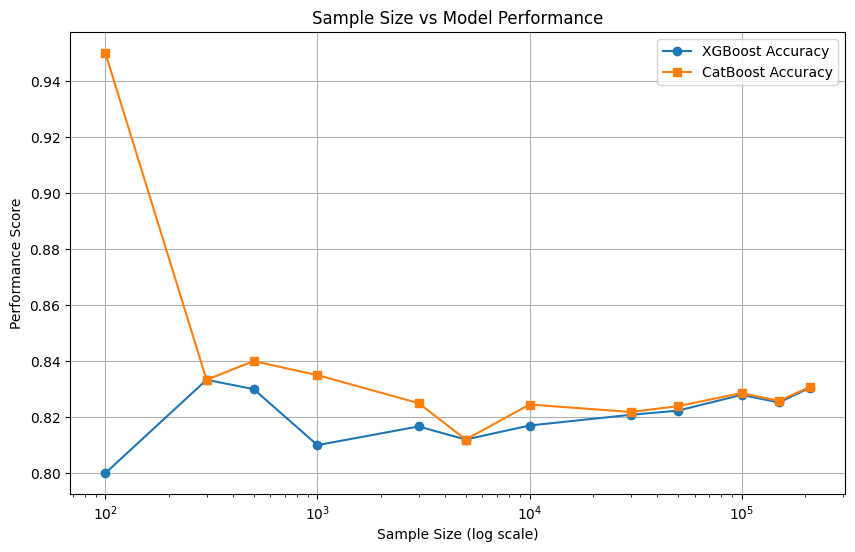

In [18]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

# XGBoost 성능 변화
plt.plot(df_results["Sample Size"], df_results["XGBoost Accuracy"], marker="o", linestyle="-", label="XGBoost Accuracy")
# plt.plot(df_results["Sample Size"], df_results["XGBoost F1"], marker="o", linestyle="--", label="XGBoost F1 Score")

# CatBoost 성능 변화
plt.plot(df_results["Sample Size"], df_results["CatBoost Accuracy"], marker="s", linestyle="-", label="CatBoost Accuracy")
# plt.plot(df_results["Sample Size"], df_results["CatBoost F1"], marker="s", linestyle="-", label="CatBoost F1 Score")

plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size (log scale)")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

데이터 사이즈가 작을 때 과적합 -> 안정화되는 경향

### 데이터 스케일링하고 재시도

In [20]:
# 스케일링하고 재시도
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# ✅ 실험할 샘플 크기 리스트
sample_sizes = [100, 300, 500, 1000, 3000, 5000, 10000, 30000, 50000, 100000, 150000, 210000]
results = []

# ✅ 각 샘플 크기에 대해 모델 성능 평가
for size in sample_sizes:
    print(f"\n🔹 데이터 크기: {size} samples")

    # ✅ 데이터 랜덤 샘플링
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=size, random_state=42, stratify=y)

    # ✅ Train-Test Split (80:20 비율)
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, train_size=0.8, random_state=42, stratify=y_sample)

    # ✅ XGBoost 학습 및 평가
    xgb_model = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.05, eval_metric="logloss", use_label_encoder=False)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    acc_xgb = accuracy_score(y_test, y_pred_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb)

    # ✅ CatBoost 학습 및 평가
    catboost_model = CatBoostClassifier(n_estimators=500, depth=6, learning_rate=0.05, verbose=0)
    catboost_model.fit(X_train, y_train)
    y_pred_cat = catboost_model.predict(X_test)

    acc_cat = accuracy_score(y_test, y_pred_cat)
    f1_cat = f1_score(y_test, y_pred_cat)

    # ✅ 결과 저장
    results.append({
        "Sample Size": size,
        "XGBoost Accuracy": acc_xgb,
        "XGBoost F1": f1_xgb,
        "CatBoost Accuracy": acc_cat,
        "CatBoost F1": f1_cat
    })

# ✅ DataFrame 변환
df_results = pd.DataFrame(results)

# ✅ 결과 저장
df_results.to_csv("sample_size_performance_analysis.csv", index=False)
print("\n✅ 데이터 크기별 성능 분석 결과 저장 완료!")



🔹 데이터 크기: 100 samples

🔹 데이터 크기: 300 samples

🔹 데이터 크기: 500 samples

🔹 데이터 크기: 1000 samples

🔹 데이터 크기: 3000 samples

🔹 데이터 크기: 5000 samples

🔹 데이터 크기: 10000 samples

🔹 데이터 크기: 30000 samples

🔹 데이터 크기: 50000 samples

🔹 데이터 크기: 100000 samples

🔹 데이터 크기: 150000 samples

🔹 데이터 크기: 210000 samples

✅ 데이터 크기별 성능 분석 결과 저장 완료!


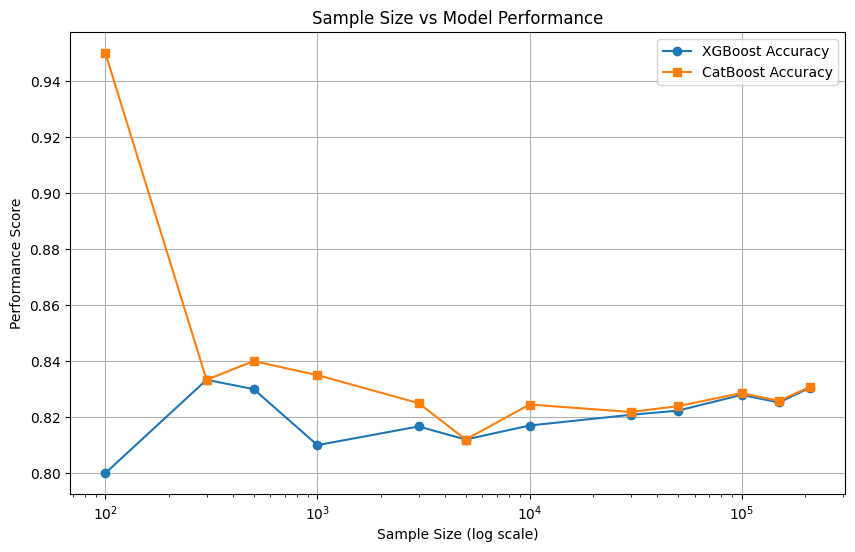

In [23]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

# XGBoost 성능 변화
plt.plot(df_results["Sample Size"], df_results["XGBoost Accuracy"], marker="o", linestyle="-", label="XGBoost Accuracy")
# plt.plot(df_results["Sample Size"], df_results["XGBoost F1"], marker="o", linestyle="--", label="XGBoost F1 Score")

# CatBoost 성능 변화
plt.plot(df_results["Sample Size"], df_results["CatBoost Accuracy"], marker="s", linestyle="-", label="CatBoost Accuracy")
# plt.plot(df_results["Sample Size"], df_results["CatBoost F1"], marker="s", linestyle="-", label="CatBoost F1 Score")

plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size (log scale)")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

**🔹 (100 ~ 1000 샘플 구간)** \
CatBoost Accuracy & F1 Score 급락 \
→ 작은 데이터에서는 CatBoost가 과적합(overfitting) 되었을 가능성 \
→ 샘플이 적을 때 고성능을 보이다가 일반화 성능 저하 & XGBoost는 상대적으로 안정적 \
→ 작은 샘플에서도 점진적인 성능 증가 

**🔹 (1000 ~ 10,000 샘플 구간)** \
CatBoost Accuracy & XGBoost Accuracy 수렴\
→ 데이터가 충분해지면서 CatBoost의 과적합 감소\
→ 두 모델 모두 안정적인 성능으로 변환

**🔹 (10,000 ~ 220,000 샘플 구간)**\
Accuracy 거의 일정 (CatBoost > XGBoost)\
→ 데이터가 많아지면서 성능 개선 폭이 둔화\
→ "더 많은 데이터가 항상 더 좋은 성능을 보장하지 않음" 


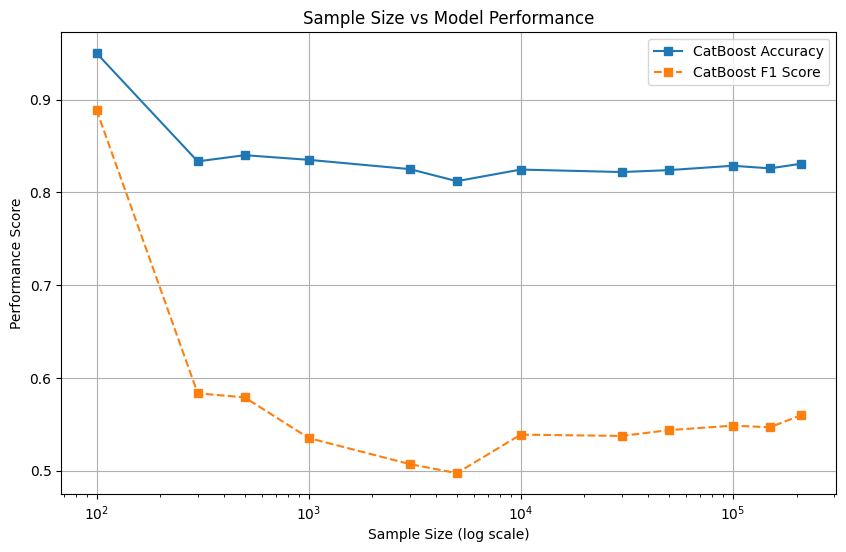

In [24]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

# XGBoost 성능 변화
# plt.plot(df_results["Sample Size"], df_results["XGBoost Accuracy"], marker="o", linestyle="-", label="XGBoost Accuracy")
# plt.plot(df_results["Sample Size"], df_results["XGBoost F1"], marker="o", linestyle="--", label="XGBoost F1 Score")

# CatBoost 성능 변화
plt.plot(df_results["Sample Size"], df_results["CatBoost Accuracy"], marker="s", linestyle="-", label="CatBoost Accuracy")
plt.plot(df_results["Sample Size"], df_results["CatBoost F1"], marker="s", linestyle="--", label="CatBoost F1 Score")

plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size (log scale)")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy.stats import ttest_ind, f_oneway


# ✅ 실험할 샘플 크기 리스트
sample_sizes = [10000, 30000, 50000, 70000, 100000, 150000, 200000]
results = []

# ✅ 성능 저장용 리스트
xgb_accuracies, xgb_f1s, xgb_times = [], [], []
cat_accuracies, cat_f1s, cat_times = [], [], []

# ✅ 고정된 테스트 데이터 (20K 샘플)
X_train_fixed, X_test, y_train_fixed, y_test = train_test_split(X, y, train_size=20000, random_state=42, stratify=y)

# ✅ 각 샘플 크기에 대해 모델 성능 평가
for size in sample_sizes:
    print(f"\n🔹 데이터 크기: {size} samples")

    # ✅ 데이터 랜덤 샘플링
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=size, random_state=42, stratify=y)

    # ✅ Train-Test Split (80:20 비율)
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.8, random_state=42, stratify=y_sample)

    # ✅ CatBoost 학습 및 평가
    start_time = time.time()
    catboost_model = CatBoostClassifier(n_estimators=500, depth=6, learning_rate=0.05, verbose=0)
    catboost_model.fit(X_train, y_train)
    cat_time = time.time() - start_time
    y_pred_cat = catboost_model.predict(X_test)

    acc_cat = accuracy_score(y_test, y_pred_cat)
    f1_cat = f1_score(y_test, y_pred_cat)
    cat_accuracies.append(acc_cat)
    cat_f1s.append(f1_cat)
    cat_times.append(cat_time)

    # ✅ 결과 저장
    results.append({
        "Sample Size": size,
        "CatBoost Accuracy": acc_cat,
        "CatBoost F1": f1_cat,
        "CatBoost Time": cat_time
    })

# ✅ DataFrame 변환
df_results = pd.DataFrame(results)
df_results.to_csv("sample_size_performance_analysis.csv", index=False)
print("\n✅ 데이터 크기별 성능 분석 결과 저장 완료!")


🔹 데이터 크기: 10000 samples

🔹 데이터 크기: 30000 samples

🔹 데이터 크기: 50000 samples

🔹 데이터 크기: 70000 samples

🔹 데이터 크기: 100000 samples

🔹 데이터 크기: 150000 samples

🔹 데이터 크기: 200000 samples

✅ 데이터 크기별 성능 분석 결과 저장 완료!


In [32]:
df_results

,Sample Size,CatBoost Accuracy,CatBoost F1,CatBoost Time
0,10000,0.823848,0.529647,2.003623
1,30000,0.827423,0.547133,3.268875
2,50000,0.827641,0.548652,4.157318
3,70000,0.827761,0.548909,4.967640
4,100000,0.827750,0.549274,6.537643
5,150000,0.827735,0.549313,7.969182
6,200000,0.827714,0.549283,9.850477


30K까지는 Accuracy 증가가 크지만, 50K 이후에는 거의 변화 없음 \
100K 이후부터는 Accuracy가 0.0001 수준으로 증가 → 추가 데이터가 큰 의미 없음 \

**📌 학습 시간 증가** 

10K 샘플: 2.00 초 \
50K 샘플: 4.16 초 (2배 증가) \
100K 샘플: 6.54 초 (50K 대비 +57% 증가) \
200K 샘플: 9.85 초 (100K 대비 +50% 증가)

성능 증가가 거의 없는 상태에서 학습 시간이 늘어나는 것은 비효율적. \
100K 이후에는 시간만 증가하고 성능 향상은 거의 없음 → <U>50K~100K가 최적</U>